In [32]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [33]:
import numpy as np
import pandas as pd

In [34]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [35]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [36]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [37]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [38]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [39]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [40]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_12_months = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_12_months)

('2017-08-23',)


In [42]:
# Calculate the date 1 year ago from the last data point in the database
a_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(a_year_ago)

2016-08-23


In [43]:
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > a_year_ago).\
    order_by(Measurement.date).all()

In [44]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation)
precipitation_df.head()


,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [45]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


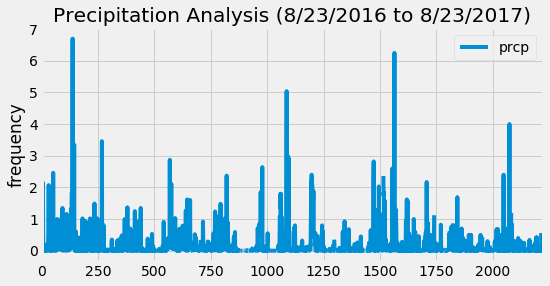

In [46]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation = precipitation_df.plot(figsize=(8,4))
precipitation.set_title("Precipitation Analysis (8/23/2016 to 8/23/2017)")
precipitation.set_ylabel('frequency')
plt.show()

![precipitation](Images/precipitation.png)

In [47]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [48]:
# Design a query to show how many stations are available in this dataset?
how_many_stations = session.query(Measurement).group_by(Measurement.station).count()

print("There are a total of {} stations available in this dataset.".format(how_many_stations))


There are a total of 9 stations available in this dataset.


In [49]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
the_most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()

print (the_most_active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [50]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
calculate_the_lowest_temperature_recorded = the_most_active_stations[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == calculate_the_lowest_temperature_recorded).all()

print (calculate_the_lowest_temperature_recorded)

USC00519281


In [51]:
# Choose the station with the highest number of temperature observations.

station_with_the_highest_number_of_temperature_observations = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281").filter(Measurement.date >"2016-08-23").all()

station_with_the_highest_number_of_temperature_observations_df = pd.DataFrame(station_with_the_highest_number_of_temperature_observations)

station_with_the_highest_number_of_temperature_observations_df.head()



,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


<function matplotlib.pyplot.show(*args, **kw)>

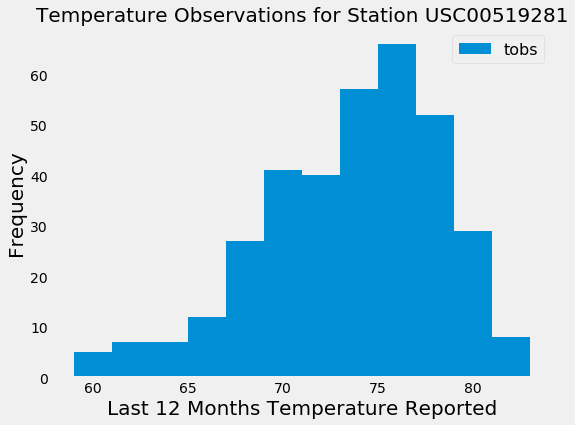

In [58]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_with_the_highest_number_of_temperature_observations_df.plot.hist(by='station', bins=12, figsize=(8,6))
plt.grid()
plt.title("Temperature Observations for Station " + calculate_the_lowest_temperature_recorded, fontsize=20)
plt.xlabel("Last 12 Months Temperature Reported", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.legend(bbox_to_anchor=(1,1), fontsize=16)

plt.show

![precipitation](Images/station-histogram.png)

In [59]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [60]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calculate_the_tmin_tavg_tmax = calc_temps('2017-07-02', '2017-07-08')
calculate_the_tmin_tavg_tmax

[(71.0, 78.11904761904762, 87.0)]

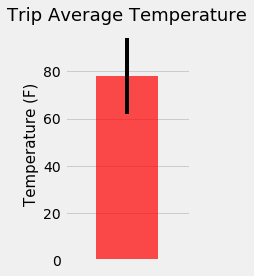

In [62]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plot_the_results_df = pd.DataFrame(calculate_the_tmin_tavg_tmax, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = plot_the_results_df['Avg Temp']


min_max_temp = plot_the_results_df.iloc[0]['Max Temp'] - plot_the_results_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(2,4), alpha=0.7, color='red')


plt.title("Trip Average Temperature", fontsize=18)

plt.ylabel("Temperature (F)", fontsize=15)
plt.xticks([])
plt.show()